# Data Lab 3

1. Common hypothesis tests for Gaussian distributed variables
2. Permutation test
3. Exercises

Turn in following the same instructions as last week. 
First copy to HW-03.ipynb and fill in your work.

## Common hypothesis tests for Gaussian distributed variables
1. Difference in means
2. Non-vanishing correlation (dependence)
3. Difference in variances

Samples $X_1, \dots , X_{N_x}$ and $Y_1, \dots , Y_{N_y}$.

Sample estimates 
- $\hat{\mu}_X$, and $\hat{\mu}_Y$ of the means
- $\hat{\sigma}^2_X$, and $\hat{\sigma}^2_Y$ of the variance
- $\hat{\rho}$ of the correlation between $X$ and $Y$

### 1. Difference in means
- Null hypothesis $H_0$ is that $\mu_X = \mu_Y$
- Test statistic 
$$T = \frac{\hat{\mu}_X - \hat{\mu}_Y }{ \hat{\sigma}_P\sqrt{\frac{1}{N_X} + \frac{1}{N_Y}}} $$ 
- Under $H_0$, $T \sim t_{N_X + N_Y -2}$
- Decision rule: reject $H_0$ if $$|T_{\text{obs}}| > t_{\alpha/2, N_X + N_Y -2}$$

The critical value $t_{\alpha/2, N_X + N_Y -2}$ depends on the significance level $\alpha$ according to
$$P( |T| > t_{\alpha/2, N_X + N_Y -2} ) = \alpha$$

p-value: $p = 2(1-F(|T_{obs}|))$ where $F$ is the cdf of the t-distribution with $N_X + N_Y -2$ dof.

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

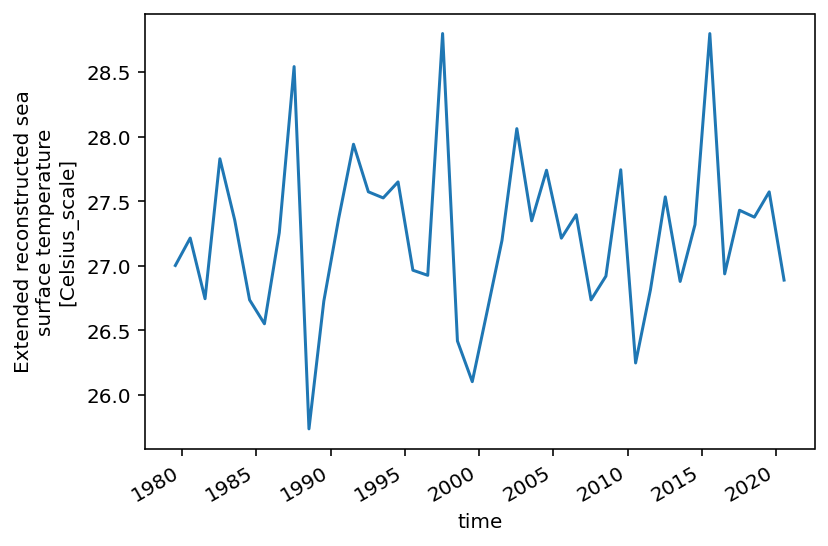

In [2]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA
n34_JJA.plot();

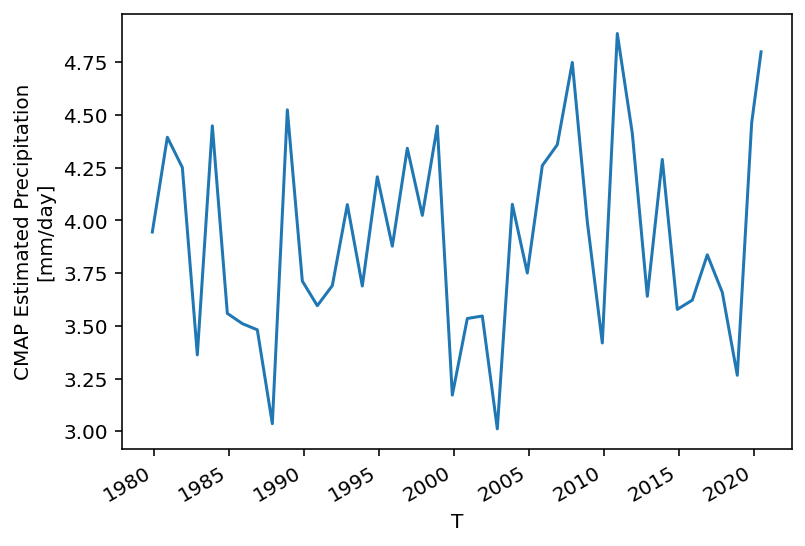

In [3]:
# Read India region rainfall
india_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.india_prcp_JJAS/dods'
india_ds = xr.open_dataset(india_url)
prcp_india = india_ds.india_prcp_JJAS
prcp_india.plot();

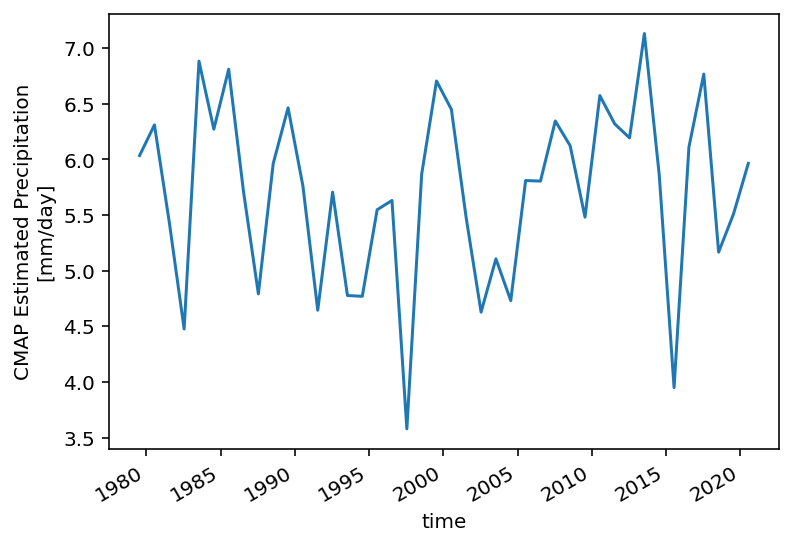

In [4]:
# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA
prcp_indo.plot();

In [5]:
n34 = n34_JJA - n34_JJA.mean()
t_nina = n34.values <= -0.4
t_nino = n34.values >= 0.33

np.quantile(n34,np.array([0.25, 0.75]))

array([-0.40281487,  0.33051777])

### - T-test example

In [6]:
# T-test for difference in means
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)
df = Nx + Ny - 2

X = prcp_indo[t_nina].values
Y = prcp_indo[t_nino].values

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
indo_t = (X.mean() - Y.mean())/np.sqrt(pooled_var)/np.sqrt(1./Nx + 1./Ny)
indo_p = 2*(1-stats.t.cdf(np.abs(indo_t), df=df))

print([indo_t,indo_p])
print(stats.ttest_ind(X, Y))

[7.070806276715802, 7.430543880193596e-07]
Ttest_indResult(statistic=6.741749330669102, pvalue=1.4722622133476326e-06)


In [7]:
# T-test for difference in means
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_india[t_nina]
Y = prcp_india[t_nino]

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
india_t = (X.mean() - Y.mean())/np.sqrt(pooled_var)/np.sqrt(1/Nx + 1/Ny)
india_p = 2*(1-stats.t.cdf(np.abs(india_t), df=df))

print([india_t,india_p])
print(stats.ttest_ind(X, Y))

[<xarray.DataArray 'india_prcp_JJAS' ()>
array(1.72940981), 0.09914113271948022]
Ttest_indResult(statistic=1.6489275267329377, pvalue=0.11478227725285987)


In [8]:
# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

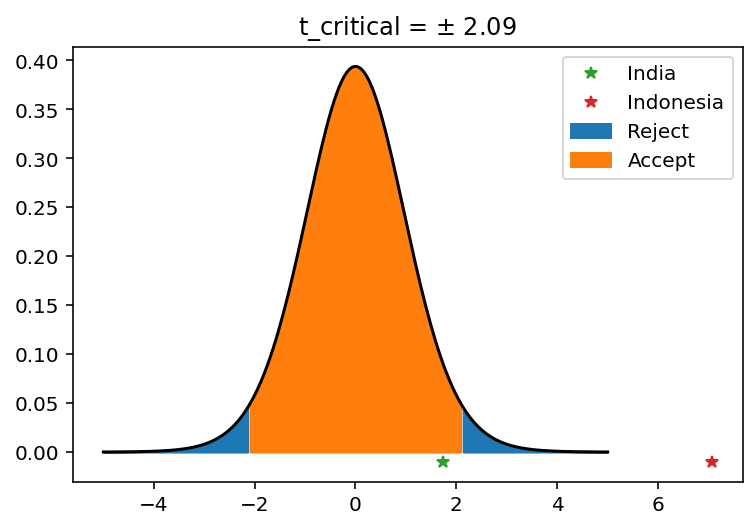

In [9]:
df = Nx + Ny - 2

alpha = 0.05
t_05 = stats.t.ppf(1 - 0.05/2, df = df)
plt.title('t_critical = $\pm$ {:4.2f}'.format(t_05))

ts = np.linspace(-5, 5, 200)
plt.plot(ts, stats.t.pdf(ts, df=df), color='k');
ts_left = ts[ts <= - t_05]
ts_right = ts[ts >= t_05]
ts_middle = ts[ (ts < t_05) & (ts > - t_05) ]


plt.fill_between(ts_left, stats.t.pdf(ts_left, df=df), color = colors[0], label='Reject')
plt.fill_between(ts_right, stats.t.pdf(ts_right, df=df), color = colors[0])
plt.fill_between(ts_middle, stats.t.pdf(ts_middle, df=df), color = colors[1], label='Accept')

plt.plot(india_t, -0.01, '*', color = colors[2], label = 'India')
plt.plot(indo_t, -0.01, '*', color = colors[3], label = 'Indonesia')

plt.legend();

### 1b Difference in means *confidence interval*

Recall that

$$T = \frac{\hat{\mu}_X - \hat{\mu}_Y - (\mu_X - \mu_Y )}{ \hat{\sigma}_P\sqrt{\frac{1}{N_X} + \frac{1}{N_Y}}}  \sim t_{N_x + N_y - 2}$$ 

Why is $T$ not a test statistic?

Nonetheless 

$$ P (- t_{\alpha/2, N_X + N_Y - 2} \le T \le t_{\alpha/2, N_X + N_Y -2}) = 1 - \alpha$$

without assuming the null hypothesis.

$$ P (- t_{\alpha/2} \le T \le t_{\alpha/2}) = 1 - \alpha$$

$$ P \left(- t_{\alpha/2} \le \frac{\hat{\mu}_X - \hat{\mu}_Y - (\mu_X - \mu_Y )}{ \hat{\sigma}_{X-Y}} \le t_{\alpha/2} \right) = 1 - \alpha$$
$\hat{\sigma}_{X-Y} = \hat{\sigma}_P\sqrt{\frac{1}{N_X} + \frac{1}{N_Y}}$

$$ P \left(- t_{\alpha/2} \hat{\sigma}_{X-Y} \le \hat{\mu}_X - \hat{\mu}_Y - (\mu_X - \mu_Y ) \le t_{\alpha/2} \hat{\sigma}_{X-Y} \right) = 1 - \alpha$$

$$ P \left(- t_{\alpha/2} \hat{\sigma}_{X-Y} - (\hat{\mu}_X - \hat{\mu}_Y) \le  - (\mu_X - \mu_Y ) \le t_{\alpha/2} \hat{\sigma}_{X-Y}  - (\hat{\mu}_X - \hat{\mu}_Y) \right) = 1 - \alpha$$

$$ P \left( t_{\alpha/2} \hat{\sigma}_{X-Y} + (\hat{\mu}_X - \hat{\mu}_Y) \ge  (\mu_X - \mu_Y ) \ge - t_{\alpha/2} \hat{\sigma}_{X-Y}  + (\hat{\mu}_X - \hat{\mu}_Y) \right) = 1 - \alpha$$

$$ P \left( (\hat{\mu}_X - \hat{\mu}_Y) - t_{\alpha/2} \hat{\sigma}_{X-Y}  \le  (\mu_X - \mu_Y ) \le  (\hat{\mu}_X - \hat{\mu}_Y) +  t_{\alpha/2} \hat{\sigma}_{X-Y} \right) = 1 - \alpha$$

$$ P( (\mu_X - \mu_Y ) \in I ) = 1 - \alpha$$
where

$$ I = [(\hat{\mu}_X - \hat{\mu}_Y) - t_{\alpha/2} \hat{\sigma}_{X-Y}, (\hat{\mu}_X - \hat{\mu}_Y) + t_{\alpha/2} \hat{\sigma}_{X-Y}]$$

Note the interval is random. Interpretation? 

### - Example

In [10]:
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_indo[t_nina].values
Y = prcp_indo[t_nino].values

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
indo_CI = (X.mean() - Y.mean()) + np.sqrt(pooled_var)*np.array([-t_05, t_05])
# Does not include zero
indo_CI

array([0.47450949, 2.60533499])

In [11]:
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_india[t_nina].values
Y = prcp_india[t_nino].values

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
india_CI = (X.mean() - Y.mean()) + np.sqrt(pooled_var)*np.array([-t_05, t_05])
# Includes zero
india_CI

array([-0.68183157,  1.42752383])

### 2. Non-vanishing correlation (dependence)
- Null hypothesis $H_0$ is that $\rho_{XY} = 0$.
- Test statistic 
$$T = \frac{\hat{\rho} \sqrt{N - 2}}{\sqrt{1 - \hat{\rho}^2}}$$
- Under $H_0$, $T \sim t_{N - 2}$
- Decision rule: reject $H_0$ if $$|T_{\text{obs}}| > t_{\alpha/2, N -2}$$

The critical value $t_{\alpha/2, N_X + N_Y -2}$ depends on the significance level $\alpha$ according to
$$P( |T| > t_{\alpha/2, N - 2} ) = \alpha .$$

*Handy* rule of *thumb*: reject at the 5% significance level if $\hat{\rho} < \frac{2}{\sqrt{N}}$

In [12]:
# Threshold for statistical significance at the 5% level
2/np.sqrt(42)

0.3086066999241838

In [13]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

### - Example 1

-0.757529


0.3086066999241838

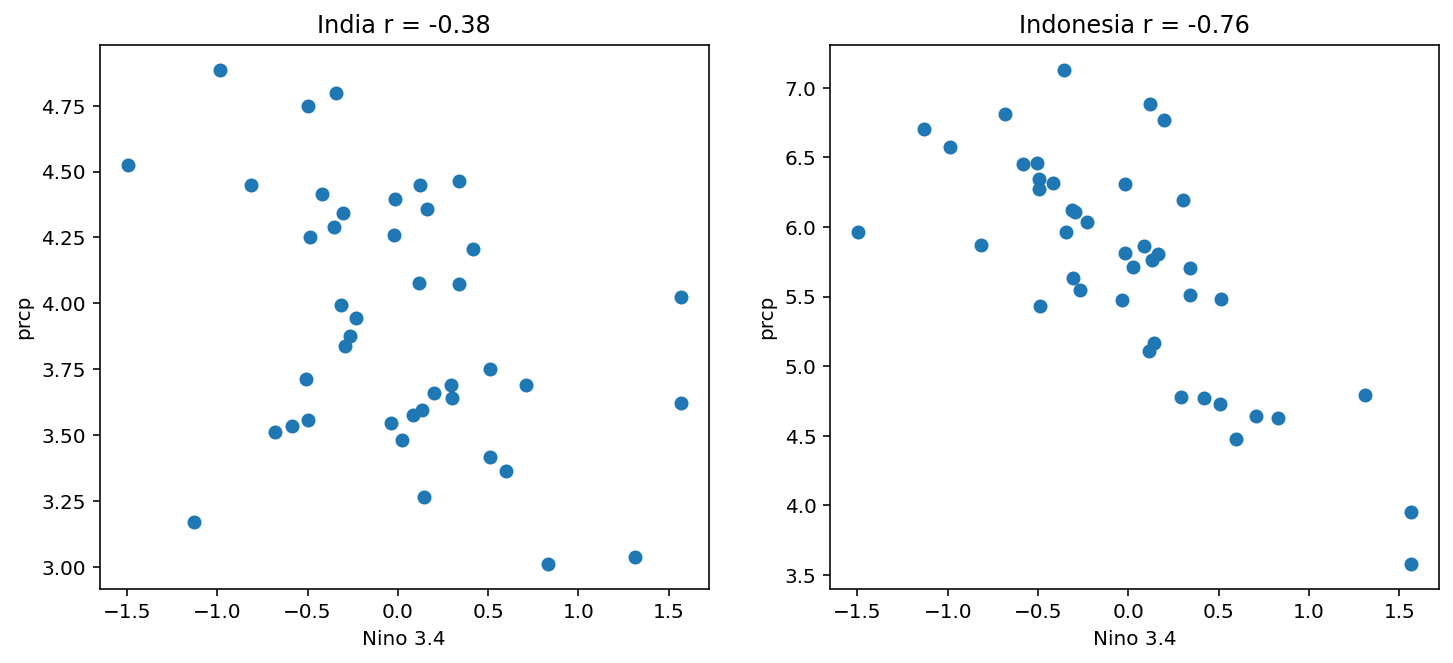

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,5),sharey=False,sharex=True)

r_indo = cor(n34,prcp_indo)
r_india = cor(n34,prcp_india.values)
print(r_indo)

axs[0].plot(n34,prcp_india,'o');
axs[0].set_xlabel('Nino 3.4');
axs[0].set_ylabel('prcp');

axs[1].plot(n34,prcp_indo,'o');
axs[1].set_xlabel('Nino 3.4');
axs[1].set_ylabel('prcp');

axs[0].set_title('India' + ' r = {:4.2f}'.format(r_india));
axs[1].set_title('Indonesia' + ' r = {:4.2f}'.format(r_indo));

N = len(n34)
2/np.sqrt(N) #<--------------only output

In [15]:
# Read global rainfall
prcp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_JJA/0/pop/dods'
prcp_ds = xr.open_dataset(prcp_url)
prcp_JJA = prcp_ds.prcp_JJA
prcp_JJA.load()

<xarray.DataArray 'prcp_JJA' (T: 42, Y: 72, X: 144)>
array([[[0.25999996, 0.25666663, 0.2533333 , ..., 0.26666662,
         0.2633333 , 0.22999999],
        [0.15999998, 0.15666665, 0.15666665, ..., 0.16666666,
         0.15999998, 0.14333332],
        [0.10999999, 0.10999999, 0.10999999, ..., 0.10999999,
         0.10999999, 0.09999999],
        ...,
        [0.5066666 ,        nan,        nan, ..., 0.5566666 ,
         0.57333326, 0.54999995],
        [0.47666663, 0.4933333 , 0.47999996, ..., 0.5799999 ,
         0.5299999 , 0.5033333 ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.42999998, 0.42333332, 0.41666663, ..., 0.43666664,
         0.4333333 , 0.38999996],
        [0.23999998, 0.23666665, 0.22999999, ..., 0.26333332,
         0.2533333 , 0.22333331],
        [0.13333333, 0.12666665, 0.12666665, ..., 0.15333332,
         0.14666665, 0.12666665],
...
        [0.58333325,        nan,        nan, ..., 0.7933333 ,
         0.67999995, 0.73999995],
        [0.6033333 , 0.57333326, 0.4833333 , ..., 0.62999994,
         0.5833333 , 0.5433333 ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.16333333, 0.16333333, 0.15666665, ..., 0.16999999,
         0.16666666, 0.16666666],
        [0.21999998, 0.21999998, 0.21999998, ..., 0.21999998,
         0.21999998, 0.22333331],
        [0.25999996, 0.2533333 , 0.2533333 , ..., 0.2833333 ,
         0.27666664, 0.26666665],
        ...,
        [0.5166666 ,        nan,        nan, ..., 0.73999995,
         0.62999994, 0.6766666 ],
        [0.4933333 , 0.4633333 , 0.36999997, ..., 0.5566666 ,
         0.50999993, 0.4433333 ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -88.75 -86.25 -83.75 -81.25 ... 81.25 83.75 86.25 88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * T        (T) datetime64[ns] 1979-07-17T12:00:00 1980-07-17 ... 2020-07-17
Attributes:
    long_name:           CMAP Estimated Precipitation
    maxncolor:           254
    standard_name:       lwe_precipitation_rate
    ncolor:              254
    file_missing_value:  -999.0
    units:               mm/day
    history:             Averaged in T with overlapping interval 3\nBoxes wit...

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Correlation JJA precipitation with Nino 3.4')

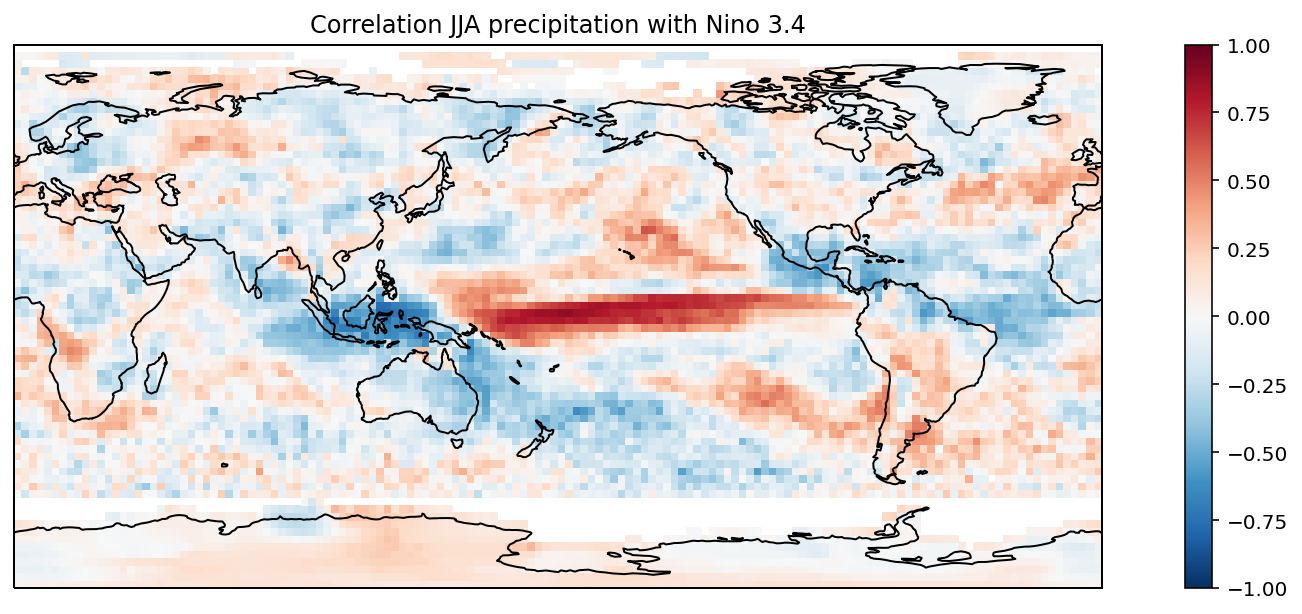

In [16]:
r_prcp = xr.corr(prcp_JJA, n34, dim='T')

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

r_prcp.plot(ax=ax, vmax = 1, transform=proj_dta)
ax.coastlines();
ax.set_title('Correlation JJA precipitation with Nino 3.4')

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'The eastern Pacfic is relatively cool and there is little rainfall there')

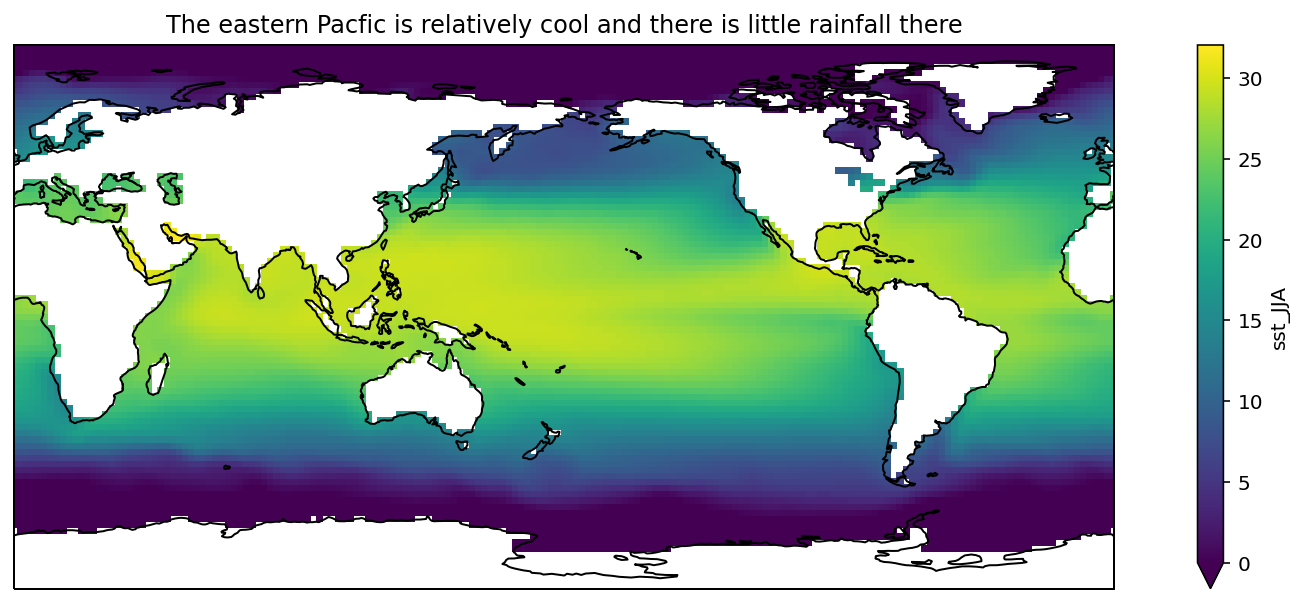

In [17]:
# read SST
sst_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.sst_JJA/dods'
sst_ds = xr.open_dataset(sst_url)
sst_JJA = sst_ds.sst_JJA

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

sst_JJA.mean("T").plot(ax=ax, vmin=0, transform=proj_dta)
ax.coastlines();
ax.set_title('The eastern Pacfic is relatively cool and there is little rainfall there')

### - Example 2

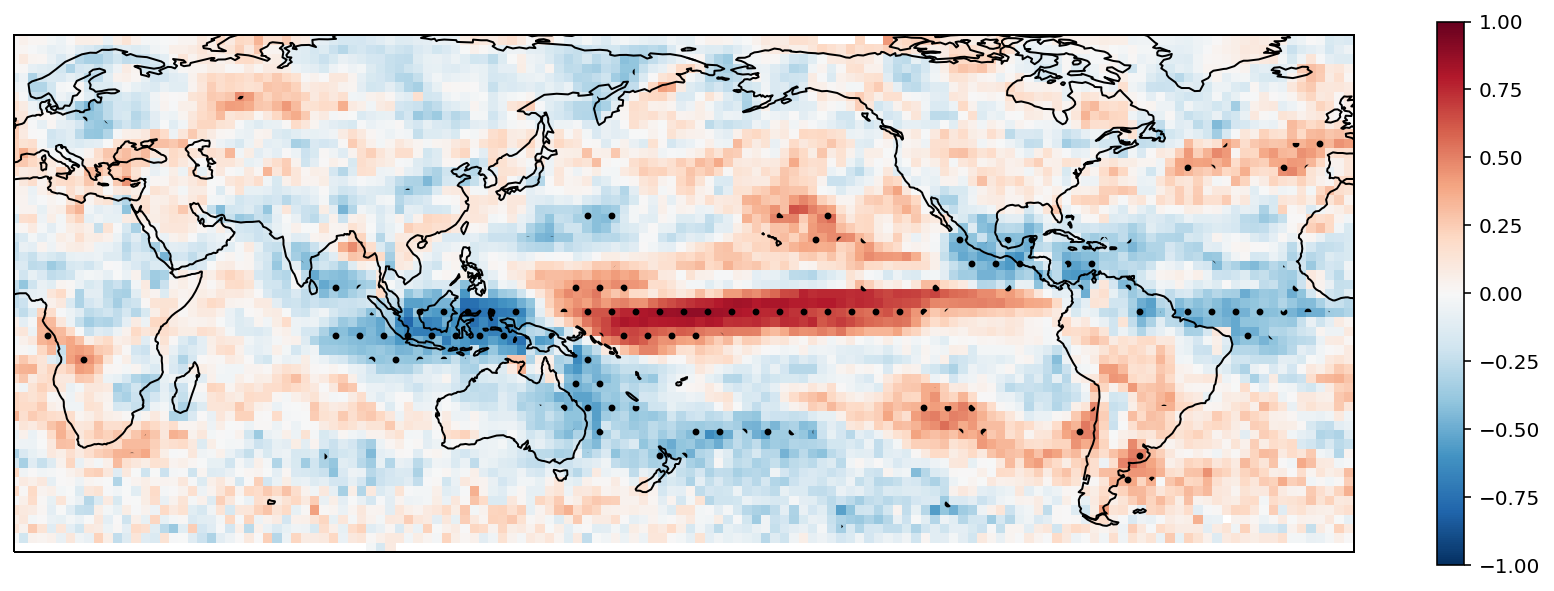

In [18]:
fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

N = len(n34)

r_prcp.plot(ax=ax, vmax = 1, transform=proj_dta)
ax.coastlines();
dta = r_prcp
lon = dta.X
lat = dta.Y
sig_value = 2/np.sqrt(N) #<---
mask = np.zeros(dta.shape) ; mask[(np.abs(dta)<sig_value) | np.isnan(dta)] = np.nan
plt.contourf(lon, lat, mask, hatches=['.'], colors='none', transform=proj_dta);

### 3. Difference in variances
- Null hypothesis $H_0$ is that $\sigma^2_X = \sigma^2_Y$
- Test statistic 
$$F = \frac{\hat{\sigma}^2_X}{\hat{\sigma}^2_Y} \qquad \hat{\sigma}^2_X > \hat{\sigma}^2_Y$$
- Under $H_0$, $F \sim F_{N_X - 1, N_Y - 1}$
- Decision rule: reject $H_0$ if $$ F_{\text{obs}} > F_{\alpha/2, N_X - 1, N_Y - 1}$$

The critical value $F_{\alpha/2, N_X - 1, N_Y - 1}$ depends on the significance level $\alpha$ according to
$$P( F > F_{\alpha/2, N_X - 1, N_Y - 1} ) = \alpha .$$

### - Example

In [19]:
# Test for difference in variance
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_indo[t_nina]
Y = prcp_indo[t_nino]
print(Y.var() > X.var())

indo_F = Y.var(ddof=1)/X.var(ddof=1)
print(' F = {:4.2f}'.format(indo_F.values))

alpha = 0.05
f_05 = stats.f.ppf(1-alpha/2, Nx - 1, Ny - 1)
print(' f_critical = {:4.2f}'.format(f_05))
print('Cannot reject the null.')

<xarray.DataArray 'indonesia_prcp_JJA' ()>
array(True)
 F = 2.59
 f_critical = 3.72
Cannot reject the null.


In [20]:
# Test for difference in variance

Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_india[t_nina]
Y = prcp_india[t_nino]
print(Y.var(ddof=1) > X.var(ddof=1))

india_F = X.var()/Y.var()
print(' F = {:4.2f}'.format(india_F.values))

from scipy.stats import f
alpha = 0.05
f_05 = f.ppf(1-alpha/2, Nx - 1, Ny - 1)
print(' f_critical = {:4.2f}'.format(f_05))
print('Cannot reject the null.')

<xarray.DataArray 'india_prcp_JJAS' ()>
array(False)
 F = 1.56
 f_critical = 3.72
Cannot reject the null.


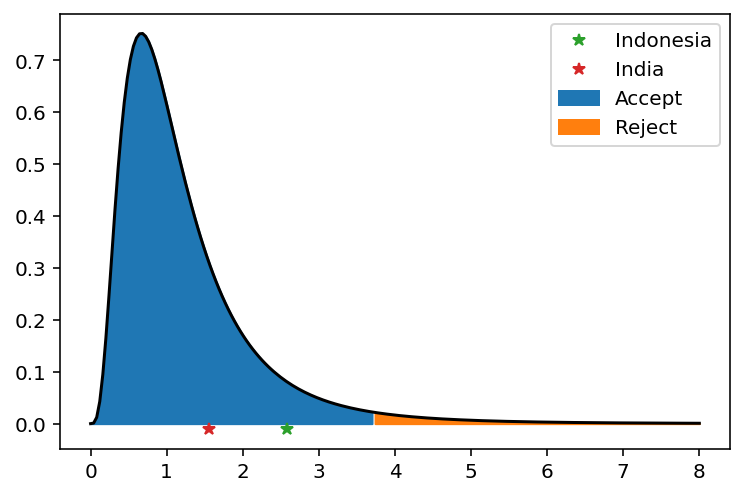

In [21]:
fs = np.linspace(0, 8, 200)
dfn = Nx - 1
dfd = Ny - 1
plt.plot(fs, f.pdf(fs, dfn, dfd), color='k');

fs_left = fs[fs <= f_05]
fs_right = fs[fs >= f_05]


plt.fill_between(fs_left, f.pdf(fs_left,  dfn, dfd), color = colors[0], label='Accept')
plt.fill_between(fs_right, f.pdf(fs_right,  dfn, dfd), color = colors[1], label='Reject')


plt.plot(indo_F, -0.01, '*', color = colors[2], label = 'Indonesia')
plt.plot(india_F, -0.01, '*', color = colors[3], label = 'India')
plt.legend();

# Non-parametric tests

(parametric b/c Gaussian)

1. Wilcoxon rank-sum test
2. Kolmogorov–Smirnov test

## Permutation test
Exact significance test that makes no assumptions about distributions

In the context of the difference in means test. 
1. Compute the difference in sample means $d^* = \hat{\sigma}_X - \hat{\sigma}_Y$ 
2. Pool the $N_X + N_Y$ samples together $X_1, \dots, X_{N_X}, Y_1, \dots, Y_{N_Y}$ and then permute their order randomly. Compute the difference between the mean of the first $N_X$ and the following $N_Y$ samples, and denote it as $d_1$.
3. Repeat with a new permutation and denote the new difference as $d_2$. And so on until all (or a large number of) permutations have been used.
4. Compute the fraction $f$ of randomly permuted results ($d_i$s) that are greater than the observed one $d^*$. This fraction $f$ is the test statistic. 
5. Under the null hypothesis that $X$ and $Y$ come from the same distribution, the sampling distribution of $f$ is the the uniform distribution between zero and one. Why?

In other words,
$$ P(f > 1 - \alpha/2 \text{ OR } f < \alpha/2 ) = \alpha $$
which means that the critical value of $f$ is $\alpha/2$, and the associated p-value is $2f$.

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


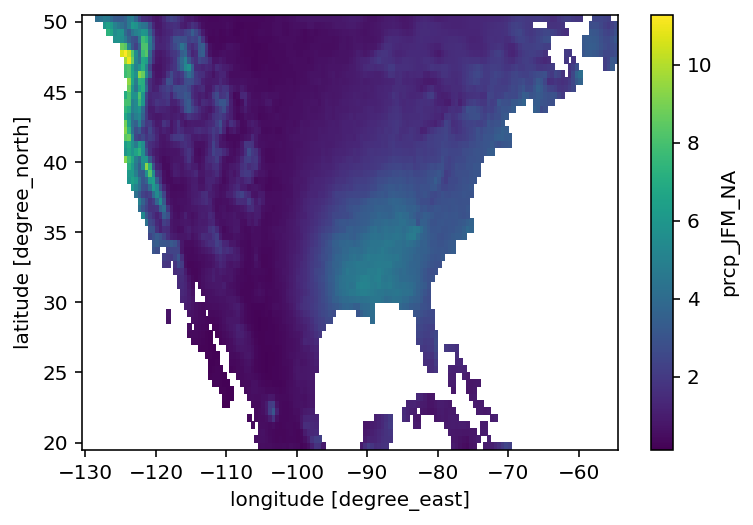

In [22]:
# Read JFM North American precipitation and plot its mean
prcp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_JFM_NA/dods'
prcp_ds = xr.open_dataset(prcp_url)
prcp = prcp_ds.prcp_JFM_NA
prcp.mean('T').plot();

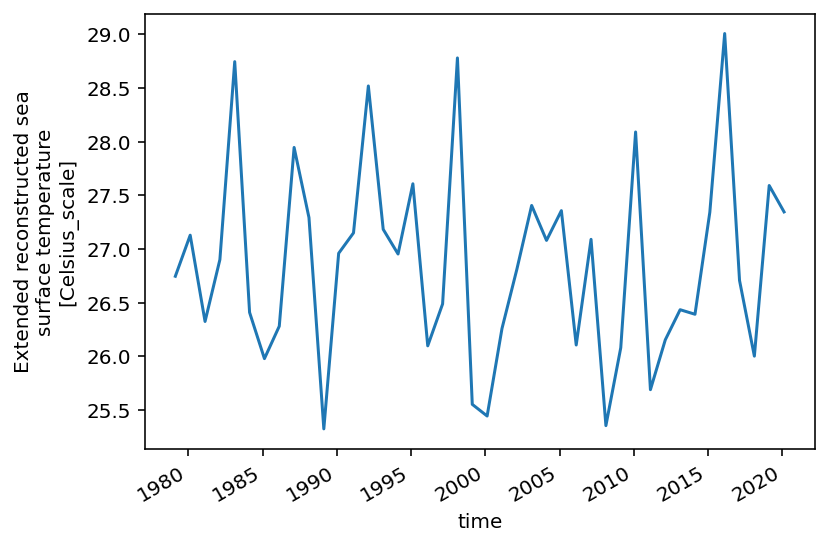

In [23]:
# Read JFM Nino 3.4
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JFM/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34_JFM
n34.plot();

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


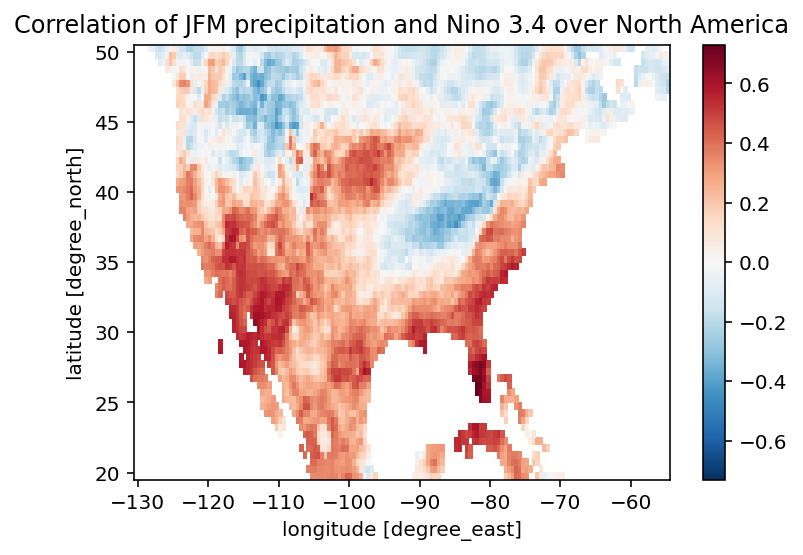

In [24]:
n34_prcp_corr = xr.corr(n34, prcp, dim = 'T') 
n34_prcp_corr.plot();
plt.title('Correlation of JFM precipitation and Nino 3.4 over North America');

# Week 3 exercises

1. 10 points. Why does the t-test calculation by "hand" below give a different answer than the t-test package? Read the documentation for `numpy.var` and correct the code so the results agree. 

In [25]:
# T-test for difference in means
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_india[t_nina].values
Y = prcp_india[t_nino].values

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
india_t = (X.mean() - Y.mean())/np.sqrt(pooled_var)/np.sqrt(1/Nx + 1/Ny)
india_p = 2*(1-stats.t.cdf(np.abs(india_t), df=df))

print([india_t,india_p])
print(stats.ttest_ind(X, Y))

[1.7294097823199035, 0.09914113731602048]
Ttest_indResult(statistic=1.6489275267329377, pvalue=0.11478227725285987)


2. 10 points. Compute the p-values for the differences in JJA precipitation variance over India and Indonnesia. 

In [26]:
# CODE here
# Use the variables india_F, indo_F, Nx, Ny etc

3. 15 points. Plot the correlation of JFM rainfall over North America. Include a coastline and "dots" at the gridpoints that are statistically significant at the 5% level.
    - What percent of gridpoints (land only) are statistically significant at the 5% level?  

4. 15 points. Find the 25th and 75th percentiles of JFM Nino 3.4 anomalies and use these percentiles to define "warm" and "cool" ENSO conditions. Compute the difference in JFM precipitation over North America between warm and cool years. Include a coastline and "dots" at the gridpoints that are statistically significant at the 5% level.

5. 10 points. 
    - What is the expected value (population) of sample 1? Of Sample 2?
    - Add comments to the permutation test code based on sample means
    - According to the permutation test are the two samples statistically significantly different at the 5% level? What is the p-value?
    - Watch the video https://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/

In [27]:
np.random.seed(42)

# Sample 1
nx = 5
x = np.random.normal(size=nx)
# Sample 2
ny = 7
y = np.random.normal(size=ny) + 1.1

In [28]:
# Concatenate the two sample
xy = np.concatenate((x,y))
print(x)
print(xy[:nx])
print(y)
print(xy[nx:])

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
[0.86586304 2.67921282 1.86743473 0.63052561 1.64256004 0.63658231
 0.63427025]
[0.86586304 2.67921282 1.86743473 0.63052561 1.64256004 0.63658231
 0.63427025]


In [29]:
# permutation test code
ts_star = np.mean(xy[:nx]) - np.mean(xy[nx:])

mc = 1000
ts = np.empty(mc)
for ii in range(0, mc):
    perm_index = np.random.permutation(nx+ny)
    xyr = xy[perm_index]
    ts[ii] = np.mean(xyr[:nx]) - np.mean(xyr[nx:])
f = np.mean(ts_star < ts)
print(f)

0.964
